In [1]:
import h5py
import numpy as np
from torch.utils.data import Dataset

class SudokuDataset(Dataset):
    def __init__(self, h5_file_path, transform=None):
        self.h5_file_path = h5_file_path
        self.transform = transform
        # Load the HDF5 data
        with h5py.File(h5_file_path, 'r') as f:
            self.images = np.array(f['images'])  # Shape: (N, 84, 84)
            self.labels = np.array(f['labels'])  # Shape: (N,)
        if len(self.images) > len(self.labels):
            print(f"Trimming images from {len(self.images)} to {len(self.labels)} to match labels.")
            self.images = self.images[:len(self.labels)]      
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx] 
        label = self.labels[idx] 

        # Reshape and normalize the image
        image = image.reshape(1, 84, 84).astype(np.float32) / 255.0  # Shape: (1, 84, 84)

        return image, label


In [2]:
import torch
from torch.utils.data import DataLoader, Subset
from collections import Counter
from torchvision import transforms

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Dataset from separate files
train_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_training_set.h5'  # Update with your training file path
val_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_validation_images_20k.h5'  # Update with your validation file path

train_dataset = SudokuDataset(train_file_path, transform=transform)
val_dataset = SudokuDataset(val_file_path, transform=transform)

# Determine Class Distribution in Training Dataset
all_labels = [train_dataset[i][1] for i in range(len(train_dataset))]  # Get all labels from the train set
class_counts = Counter(all_labels)  # Count samples per class
print("Class Distribution in Training Set:", class_counts)

# Identify Minority Class Count
min_class_count = min(class_counts.values())

# Step 3: Balance the Training Dataset
balanced_train_indices = []
class_sample_counts = {cls: 0 for cls in class_counts.keys()}

# Balance the training dataset
for idx, (data, label) in enumerate(train_dataset):
    if class_sample_counts[label] < min_class_count:
        balanced_train_indices.append(idx)
        class_sample_counts[label] += 1

# Create a balanced subset of the training dataset
balanced_train_dataset = Subset(train_dataset, balanced_train_indices)
print("Balanced Train Dataset Size:", len(balanced_train_dataset))

# Create DataLoaders
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Output Dataset Information
print(f"Train Dataset Size: {len(balanced_train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Trimming images from 440000 to 435000 to match labels.
Class Distribution in Training Set: Counter({False: 250000, True: 185000})
Balanced Train Dataset Size: 370000
Train Dataset Size: 370000
Validation Dataset Size: 10000


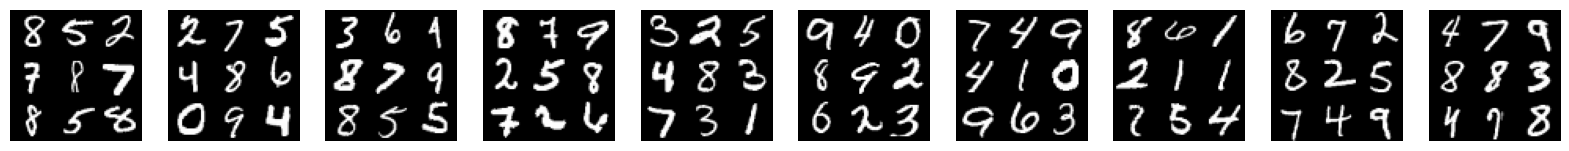

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

images, labels = next(iter(train_loader))

# Plot the images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    img = images[i].numpy().transpose((1, 2, 0)) 
    img = np.clip(img, 0, 1) 

    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')

plt.show()

In [4]:
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")  # Should be [BATCH_SIZE, 1, 84, 84]
    print(f"Label batch shape: {labels.shape}")  # Should be [BATCH_SIZE]
    break

Image batch shape: torch.Size([64, 1, 84, 84])
Label batch shape: torch.Size([64])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a more complex Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # Output: [batch, 32, 42, 42]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Output: [batch, 64, 21, 21]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: [batch, 128, 11, 11]
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: [batch, 256, 6, 6]
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.fc2_mu = nn.Linear(1024, latent_dim)
        self.fc2_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 128 * 21 * 21)  # Flatten to match the size before upsampling

        # Decoder layers to upsample the image back to 84x84
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1) 
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1) 
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 128, 21, 21)  

        z = F.relu(self.deconv1(z)) 
        z = F.relu(self.deconv2(z)) 
        x_reconstructed = torch.sigmoid(self.deconv3(z)) 
        
        return x_reconstructed



# Define the VAE model with the classifier head
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


class VAEWithClassifier(nn.Module):
    def __init__(self, latent_dim, vae, num_classes=2):
        super(VAEWithClassifier, self).__init__()
        self.vae = vae
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        reconstructed_images, mu, logvar = self.vae(x)
        class_logits = self.classifier(mu)  # Use `mu` for classification
        return reconstructed_images, mu, logvar, class_logits

# Define the VAE loss function
def vae_loss(reconstructed_images, images, mu, logvar):
    reconstructed_images = reconstructed_images.view(reconstructed_images.size(0), -1)  
    images = images.view(images.size(0), -1)  
    
    # Reconstruction loss (Binary Cross-Entropy)
    BCE = F.binary_cross_entropy(reconstructed_images, images, reduction='sum')
    
    # KL divergence loss
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss is the sum of reconstruction and KL loss
    return BCE + KL_divergence


In [88]:
import torch
import torch.nn.functional as F

def train_vae_classifier(train_loader, val_loader, model, optimizer, scheduler, epochs, device, save_path):
    best_val_loss = float('inf')  # Track the best validation loss

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        classification_loss = 0.0

        for data in train_loader:
            images, labels = data
            images = images.to(device)  # Move images to the correct device
            labels = labels.to(device).long()  # Ensure labels are of type long (for cross_entropy)
            images_flat = images.view(images.size(0), -1).to(device)  # Flatten the images
            images_reshaped = images_flat.view(-1, 1, 84, 84).to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            reconstructed_images, mu, logvar, class_logits = model(images_reshaped)

            # Calculate VAE loss
            vae_loss_value = vae_loss(reconstructed_images, images_reshaped, mu, logvar)

            # Calculate classification loss (cross entropy)
            class_loss = F.cross_entropy(class_logits, labels)

            # Total loss
            total_loss = vae_loss_value + class_loss

            # Backward pass and optimize
            total_loss.backward()
            optimizer.step()

            running_loss += vae_loss_value.item()
            classification_loss += class_loss.item()

        # Print statistics after every epoch
        avg_loss = running_loss / len(train_loader.dataset)
        avg_class_loss = classification_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, VAE Loss: {avg_loss:.4f}, Classification Loss: {avg_class_loss:.4f}")

        # Validation Loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_class_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device).long()  # Ensure labels are of type long
                images_flat = images.view(images.size(0), -1).to(device)  # Flatten
                images_reshaped = images_flat.view(-1, 1, 84, 84).to(device)

                reconstructed_images, mu, logvar, class_logits = model(images_reshaped)
                vae_loss_value = vae_loss(reconstructed_images, images_reshaped, mu, logvar)
                class_loss = F.cross_entropy(class_logits, labels)

                val_loss += vae_loss_value.item()
                val_class_loss += class_loss.item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_class_loss = val_class_loss / len(val_loader.dataset)
        print(f"Validation VAE Loss: {avg_val_loss:.4f}, Validation Classification Loss: {avg_val_class_loss:.4f}")

        # Save the model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_file = f"{save_path}/vae_classifier_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), save_file)
            print(f"Model saved to {save_file}")

        # Step the scheduler
        scheduler.step(avg_val_loss) 


In [ ]:
latent_dim = 128
vae = VAE(latent_dim)
model = VAEWithClassifier(latent_dim, vae)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
save_path = '/kaggle/working/'
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

epochs = 20
train_vae_classifier(train_loader, val_loader, model, optimizer, scheduler,epochs, device,save_path)


Epoch 1/20, VAE Loss: 1440.8360, Classification Loss: 0.0094
Validation VAE Loss: 1378.1604, Validation Classification Loss: 0.0103
Model saved to /kaggle/working//vae_classifier_epoch_1.pth
Epoch 2/20, VAE Loss: 1240.0314, Classification Loss: 0.0088
Validation VAE Loss: 1310.5790, Validation Classification Loss: 0.0100
Model saved to /kaggle/working//vae_classifier_epoch_2.pth
Epoch 3/20, VAE Loss: 1202.5792, Classification Loss: 0.0086
Validation VAE Loss: 1295.4056, Validation Classification Loss: 0.0100
Model saved to /kaggle/working//vae_classifier_epoch_3.pth
Epoch 4/20, VAE Loss: 1185.3051, Classification Loss: 0.0085
Validation VAE Loss: 1284.1237, Validation Classification Loss: 0.0097
Model saved to /kaggle/working//vae_classifier_epoch_4.pth
Epoch 5/20, VAE Loss: 1174.7767, Classification Loss: 0.0085
Validation VAE Loss: 1272.8769, Validation Classification Loss: 0.0097
Model saved to /kaggle/working//vae_classifier_epoch_5.pth
Epoch 6/20, VAE Loss: 1167.3707, Classificati

/tmp/ipykernel_30/216232457.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/vae-model/vae_classifier_epoch_19.pth'))  # 

Classification Accuracy on Test Set: 68.56%
Class 0 Accuracy: 73.57%
Class 1 Accuracy: 63.55%
Precision: 0.69
Recall: 0.69
F1 Score: 0.68


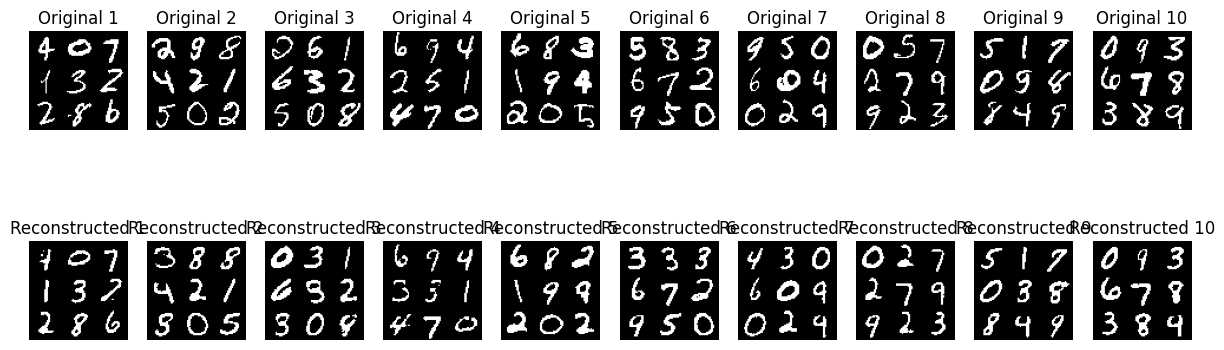

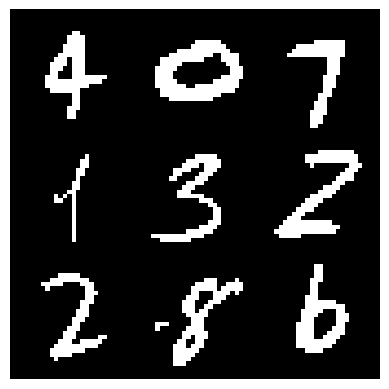

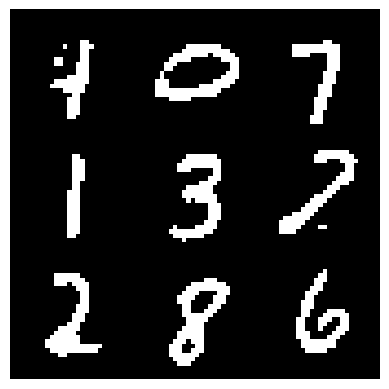

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the test dataset using your custom SudokuDataset class
h5_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_testing_set.h5'
test_dataset = SudokuDataset(h5_file_path)

# Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

latent_dim = 128
vae = VAE(latent_dim)
model = VAEWithClassifier(latent_dim, vae)
model.eval()  # Set the model to evaluation mode
model.to(device) 
model.load_state_dict(torch.load('/kaggle/input/vae-model/vae_classifier_epoch_19.pth'))  # Adjust path as needed

# Function to evaluate classification accuracy and visualize reconstructions
def evaluate_and_visualize(model, test_loader, device):
    all_true_labels = []
    all_pred_labels = []
    images_batch = None
    reconstructions_batch = None

    # Per-class accuracy calculation (initialize counters for each class)
    class_correct = [0] * 2  # For 2 classes 
    class_total = [0] * 2    # For 2 classes 

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass through the model
            output = model(images)  

            # Unpack the tuple: 
            # 1. reconstructed_images (N, 1, 84, 84)
            # 2. mu (N, 128) -> unused in classification
            # 3. logvar (N, 128) -> unused in classification
            # 4. class_logits (N, 2)
            reconstructed_images, _, _, class_logits = output

            # Get predicted labels by taking the argmax of the logits
            pred_labels = torch.argmax(class_logits, dim=1)

            # Store the true labels and predicted labels
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(pred_labels.cpu().numpy())

            # Update per-class accuracy
            for i in range(labels.size(0)):  # Iterate over each example in the batch
                label = labels[i].item()  # Get the true label
                pred_label = pred_labels[i].item()  # Get the predicted label

                if label == pred_label:
                    class_correct[label] += 1  # Increment correct count for the class
                class_total[label] += 1  # Increment total count for the class

            # Store a batch of images for visualization (if you have reconstructed images in the model)
            if batch_idx == 0:  # Visualize only the first batch
                images_batch = images.cpu().numpy()

                # If the model does return reconstructions, you can store them here
                if reconstructed_images is not None:
                    reconstructions_batch = reconstructed_images.cpu().numpy()

    # Compute overall accuracy
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    print(f"Classification Accuracy on Test Set: {accuracy * 100:.2f}%")

    # Calculate and print per-class accuracy
    for i in range(len(class_correct)):
        if class_total[i] > 0:
            per_class_accuracy = 100 * class_correct[i] / class_total[i]
            print(f"Class {i} Accuracy: {per_class_accuracy:.2f}%")

    # Calculate Precision, Recall, and F1 Score
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted')
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted')
    f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Visualize original and reconstructed images if you have them
    if reconstructions_batch is not None:
        visualize_reconstruction(images_batch, reconstructions_batch)

# Function to apply thresholding to images (binary thresholding)
# Function to apply thresholding to images (binary thresholding)
def apply_threshold(image, threshold=0.5):
    """
    Apply binary thresholding to the image.
    Pixel values above the threshold are set to 1 (white), and below are set to 0 (black).
    """
    return np.where(image > threshold, 1.0, 0.0)

# Function to visualize original and reconstructed images and display them
def visualize_reconstruction(original_images, reconstructed_images, threshold=0.5):
    # Convert images to numpy for visualization 
    original_images = original_images.squeeze()  
    reconstructed_images = reconstructed_images.squeeze() 

    # Apply thresholding to the images
    original_images = apply_threshold(original_images, threshold)
    reconstructed_images = apply_threshold(reconstructed_images, threshold)

    num_images = 10
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Original Image
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original {i + 1}")

        # Reconstructed Image
        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Reconstructed {i + 1}")

    # Display images
    plt.show()  # This will display the images in the output

    # Display individual original and reconstructed images
    plt.imshow(original_images[0], cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(reconstructed_images[0], cmap='gray')
    plt.axis('off')
    plt.show()

# Run the evaluation and visualization
evaluate_and_visualize(model, test_loader, device)